In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 
from numba import njit

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [2]:
##### function creating opinion distribution #####
def opinion_dist(N, dist_type, dist_params):
    
    if dist_type == 'normal':
        exp_value = dist_params[0]
        std_deviation = dist_params[1]
        opinion = np.random.normal(exp_value, std_deviation, N) 
        return opinion
    elif dist_type == 'uniform':
        lower_border = dist_params[0]
        upper_border = dist_params[1]
        opinion = np.random.uniform(lower_border, upper_border, N) 
        return opinion
    elif dist_type == 'beta':
        alpha = dist_params[0]
        beta = dist_params[1]
        opinion = (np.random.beta(alpha, beta, N)-0.5)*2 
        return opinion
    else:
        print('unknown dist_type "%s"' %dist_type)
        return

    
##### opinion rule weight functions #####

##### assimilative influence #####
@njit
def f_1(opinion_a, opinion_b, epsilon, mu):
    return mu

##### similarity biased influence #####
@njit
def f_2(opinion_a, opinion_b, epsilon, mu):
    dist = abs(opinion_a - opinion_b)
    
    if dist <= epsilon:
        return mu
    else:
        return 0
    
##### repulsive influence #####
@njit
def f_3(opinion_a, opinion_b, epsilon, mu):
    dist = abs(opinion_a - opinion_b)
    weight = mu*(1-1/epsilon*dist)
    return weight
    
    
##### opinion truncating function #####
@njit    
def trunc_opinion(opinion):

    if opinion < 0:
        new_opinion = 0
    elif opinion > 1:
        new_opinion = 1
    else:
        new_opinion = opinion
    
    return new_opinion
    
    
##### opinion dynamics ##### 
@njit
def opinion_dynamics(simulation_time, opinion_dist, f, epsilon, mu, N_timeline, freq_step):
    
    opinion_timeline = np.zeros((N_timeline, int(simulation_time/freq_step)))
    
    for i in range(simulation_time):
        a = np.random.randint(0, len(opinion_dist))
        b = np.random.randint(0, len(opinion_dist))
        opinion_a = opinion_dist[a]
        opinion_b = opinion_dist[b]
        
        opinion_dist[a] += f(opinion_a, opinion_b, epsilon, mu) * (opinion_b-opinion_a)
        opinion_a = opinion_dist[a]
        opinion_dist[a] = trunc_opinion(opinion_a)
        
        if i%freq_step == 0:
            
            for k in range(N_timeline):
                opinion_timeline[k, int(i/freq_step)] = opinion_dist[k]
        
    return opinion_dist, opinion_timeline

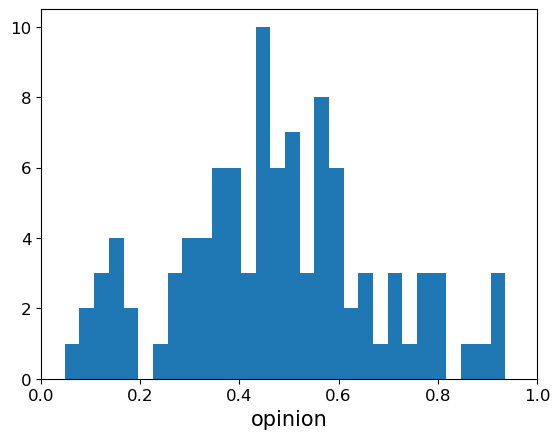

Standard deviation: 0.20129915069322524


In [3]:
##### create and plot initial opinion distribution #####

np.random.seed(45)
N = 100

opinions = opinion_dist(N, 'normal', [0.5, 0.24])

##### ensure every opinion is in the initial range #####
for i in range(N):
    while opinions[i] > 1 or opinions[i] < 0:
        opinions[i] = np.random.normal(0.5, 0.2)
        #opinions[i] = np.random.beta(0.5, 0.5)

##### create bi-polarized state #####
#opinions = np.zeros(N)
#for i in range(50): 
#    opinions[i] = 0
#    opinions[i+50] = 1
        
plt.hist(opinions, bins=30)
plt.xlabel('opinion')
plt.xlim([0,1])
plt.show()

print(f"Standard deviation: {np.std(opinions)}")

In [4]:
##### set simulation parameters #####

simulation_time = 10**4
epsilon = 0.15
mu = 0.1
freq_step = 1

##### run simulation, save new opinions and timeline #####
opinions, timeline = opinion_dynamics(simulation_time, opinions, f_1, epsilon, mu, N, freq_step)

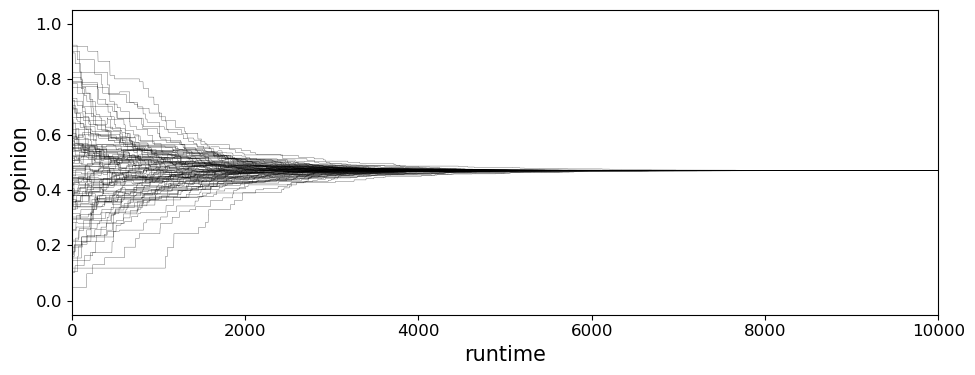

In [5]:
##### plotting the opinion timeline #####

x = np.arange(0, simulation_time, freq_step)
t = np.arange(0, int(simulation_time/freq_step), 1)

plt.figure(figsize=(10,4))
for i in range(0, 100):
    plt.plot(x, timeline[i, t], alpha=0.75, linewidth=0.25, color='black')
plt.xlim([0, simulation_time])
plt.ylim([-0.05,1.05])
plt.xlabel('runtime')
plt.ylabel('opinion')
plt.tight_layout()
#plt.savefig('.png', dpi=200)
plt.show()